In [1]:
import pandas as pd
import numpy as np
import numba
import time
import yfinance as yf
import matplotlib.pyplot as plt
from quantitative_finance.portfolio.portfolio import Portfolio

In [2]:
# Define the ticker symbols
tickers = ["SPY", "EFA", "EEM", "AGG"]

# Download historical data from Yahoo Finance
data = yf.download(tickers, start="2000-01-01", end="2022-12-31")

[*********************100%%**********************]  4 of 4 completed


In [3]:
# Calculate monthly returns
returns = data['Adj Close'].pct_change().dropna()

# Generate random weights for each month that sum to 1
np.random.seed(0)  # for reproducibility
number_of_trades = 20
random_weights = np.random.rand(number_of_trades, len(tickers))
random_weights /= random_weights.sum(axis=1)[:, np.newaxis]

weight_dates = np.sort(np.random.choice(returns.index, size=number_of_trades - 1, replace=False))
weight_dates = np.insert(weight_dates, 0, returns.index[0])

# Create a DataFrame for trades with dates as index and tickers as columns
trades = pd.DataFrame(random_weights, columns=tickers, index=weight_dates)

trade_dates = trades.index.to_numpy()
positions = trades.columns.to_numpy()
weights_target_arr = trades.to_numpy()
return_dates = returns[positions].index.to_numpy()
position_returns_arr = returns[positions].to_numpy()

In [4]:
port = Portfolio(
    position_returns=returns[positions],
    positions=positions,
    weights_target=trades
)

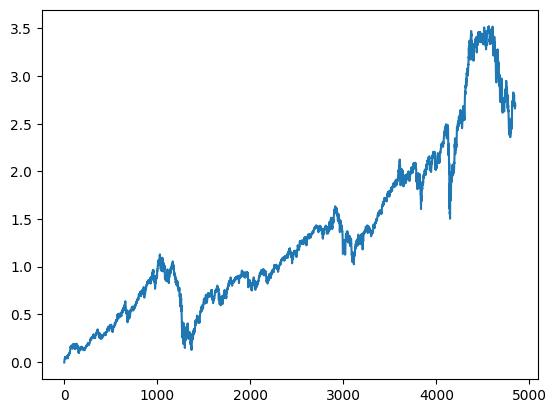

In [6]:
plt.plot(port.backtest.cumulative_performance_arr)

In [ ]:
@numba.njit(cache=True)
def calc_cumulative_performance(
        portfolio_returns_arr
):
    log_returns_arr = np.log(portfolio_returns_arr + 1)
    cumulative_performance = np.exp(np.cumsum(log_returns_arr)) - 1
    return cumulative_performance

In [127]:
import numpy as np
import pandas as pd
from typing import Optional, Union
from collections import OrderedDict

DAYS_OF_YEAR = 365.25
MONTHS_OF_YEAR = 12
QUARTERS_OF_YEAR = 4


def calc_period_dates(
        portfolio_dates: np.ndarray,
        periods: Optional[OrderedDict[str, Union[float, None]]] = None,
        return_frequency: str = 'M',
        fixed_start: bool = False
) -> OrderedDict[str, OrderedDict[str, Union[tuple, tuple]]]:
    if return_frequency not in ['D', 'M']:
        raise ValueError("return_frequency must be either 'D' or 'M'.")

    if periods is None:
        periods = _default_periods()

    adjusted_periods = _adjust_periods(
        periods,
        return_frequency
    )
    return _calculate_period_dates(
        portfolio_dates,
        adjusted_periods,
        return_frequency,
        fixed_start
    )


def _default_periods() -> OrderedDict[str, Optional[float]]:
    return OrderedDict([
        ("1M", 1 / 12),
        ("3M", 3 / 12),
        ("6M", 6 / 12),
        ("YTD", None),
        ("1Y", 1),
        ("2Y", 2),
        ("3Y", 3),
        ("5Y", 5),
        ("7Y", 7),
        ("10Y", 10),
        ("15Y", 15),
        ("20Y", 20),
        ("Inception", None)
    ])


def _adjust_periods(
        periods: OrderedDict[str, Optional[float]],
        return_frequency: str
) -> OrderedDict[str, Optional[float]]:
    factor = DAYS_OF_YEAR if return_frequency == 'D' else MONTHS_OF_YEAR
    return OrderedDict((k, v * factor if v is not None else None) for k, v in periods.items())


def _calculate_period_dates(
        portfolio_dates: np.ndarray,
        periods: OrderedDict[str, Optional[float]],
        return_frequency: str,
        fixed_start: bool
) -> OrderedDict[str, OrderedDict[str, Union[tuple, tuple]]]:
    period_dates = OrderedDict()
    start_date = portfolio_dates[0]
    start_date = pd.Timestamp(start_date)
    end_date = portfolio_dates[-1]
    end_date = pd.Timestamp(end_date)

    for period_name, period_length in periods.items():
        date_offset = _get_date_offset(period_length, return_frequency) if period_length is not None else None

        if period_name in ['Inception', 'YTD']:
            if period_name == 'Inception':
                calculated_start_date = start_date
            else:
                calculated_start_date = _find_closest_date_and_index(
                    dates=portfolio_dates,
                    target_date=pd.Timestamp(f'{end_date.year}-01-01')
                )[0]
            calculated_end_date = end_date
        else:
            calculated_end_date = start_date + date_offset if fixed_start else end_date
            calculated_start_date = end_date - date_offset if not fixed_start else start_date

        closest_start_date, start_index = _find_closest_date_and_index(
            dates=portfolio_dates,
            target_date=calculated_start_date
        )
        closest_end_date, end_index = _find_closest_date_and_index(
            dates=portfolio_dates,
            target_date=calculated_end_date
        )

        period_dates[period_name] = OrderedDict([
            ('Dates', (closest_start_date, closest_end_date)),
            ('Indices', (start_index, end_index))
        ])

    return period_dates


def _find_closest_date_and_index(dates: np.ndarray, target_date: pd.Timestamp) -> tuple:
    dates = pd.to_datetime(dates)
    closest_date_idx = np.argmin(np.abs(dates - target_date))
    return dates[closest_date_idx], closest_date_idx


def _get_date_offset(
        period_length: Optional[float],
        return_frequency: str
) -> pd.Timestamp:
    """
    Calculates the start date from the end date and period length.
    ...
    """
    if period_length is None:
        raise ValueError("Period length cannot be None for calculating start date.")

    offset_int = int(period_length)

    if return_frequency == 'D':
        date_offset = pd.DateOffset(days=offset_int)
    elif return_frequency == 'M':
        date_offset = pd.DateOffset(months=offset_int)
    else:
        date_offset = None

    return date_offset




In [128]:
returns.index[0]

Timestamp('2003-09-30 00:00:00')

In [129]:
returns.index.values[0] == returns.index[0]

True

In [134]:
period_dict = calc_period_dates(
    portfolio_dates=returns.index.values,
    return_frequency='M',
    fixed_start=False
)

In [135]:
period_dict

OrderedDict([('1M',
              OrderedDict([('Dates',
                            (Timestamp('2022-11-30 00:00:00'),
                             Timestamp('2022-12-30 00:00:00'))),
                           ('Indices', (4826, 4847))])),
             ('3M',
              OrderedDict([('Dates',
                            (Timestamp('2022-09-30 00:00:00'),
                             Timestamp('2022-12-30 00:00:00'))),
                           ('Indices', (4784, 4847))])),
             ('6M',
              OrderedDict([('Dates',
                            (Timestamp('2022-06-30 00:00:00'),
                             Timestamp('2022-12-30 00:00:00'))),
                           ('Indices', (4720, 4847))])),
             ('YTD',
              OrderedDict([('Dates',
                            (Timestamp('2021-12-31 00:00:00'),
                             Timestamp('2022-12-30 00:00:00'))),
                           ('Indices', (4596, 4847))])),
             ('1Y',
           